In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [100]:
df = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t', names=['label','message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [101]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [102]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000219AB08F948>,
      dtype=object)

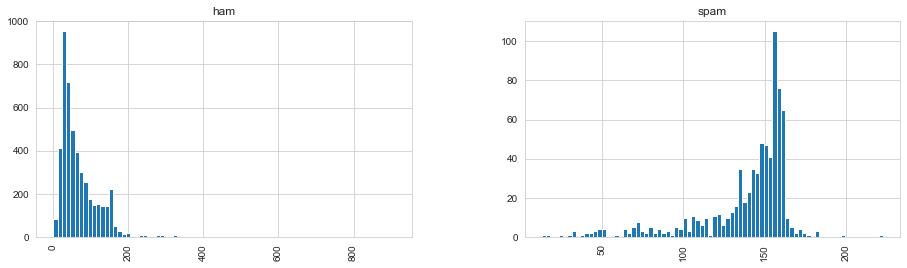

In [103]:
sns.set_style('whitegrid')
df.hist(column='length', by='label', bins=80, figsize=(15,4))

###  message text preprocessing
Our main issue with our data is that it is all in text format (strings). The classification algorithms will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the  [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

In [115]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')[0:10]
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Let's try  text processing on a single msg**

In [116]:
msg = df['message'][1]
msg

'Ok lar... Joking wif u oni...'

In [119]:
msgpro = [char for char in msg if char not in string.punctuation]
msgpro = ''.join(msgpro)
msgpro

'Ok lar Joking wif u oni'

In [118]:
msgpro = [word for word in msgpro.split() if word.lower() not in stopwords.words('english')]
msgpro

['Ok', 'lar', 'Joking', 'wif', 'u', 'oni']

In [120]:
# Stemming with PorterStemmer handling Stop Words
msgpro = [ps.stem(word) for word in msgpro.split() if word.lower() not in set(stopwords.words('english'))]
msgpro

['Ok', 'lar', 'joke', 'wif', 'u', 'oni']

#### now create a text processing function
let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

In [121]:

def textprocess(mess):
    #remove punction from message
    nopunc = [char for char in mess if char not in string.punctuation]
    #join characters to form sentence(msg) again
    nopunc = ''.join(nopunc)
    #Perform stemming and remove stopwords from msg 
    msg = [ps.stem(word) for word in nopunc.split() if word.lower() not in set(stopwords.words('english'))]
    
    return msg


### Train Test Split

In [122]:
X = df['message']
y = df['label']

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=101)

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)    

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin:

1) SciKit Learn's **CountVectorizer** will convert a collection of text documents to a matrix of token counts.

  Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because   of this, SciKit Learn will output a [Sparse Matrix](https://en.wikipedia.org/wiki/Sparse_matrix).


2) **TF-IDF** stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

3) With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms.I found Support Vector Machine classifier algorithm is a good choice.

### Creating a Data Pipeline

Let's run our model and then predict off the test set. We will use SciKit Learn's [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) capabilities to store a pipeline of workflow. 

In [129]:
pipe = Pipeline([
    ('bow', CountVectorizer(analyzer=textprocess)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors using Support Vector Machine classifier
])

In [130]:
pipe.fit(xtrain,ytrain)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function textprocess at 0x00000219A7CF74C8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+...
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0

In [131]:
predictions = pipe.predict(xtest)

In [132]:
from sklearn.metrics import classification_report
print(classification_report(ytest, predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1227
        spam       1.00      0.80      0.89       166

    accuracy                           0.98      1393
   macro avg       0.99      0.90      0.94      1393
weighted avg       0.98      0.98      0.98      1393



#### Thanks for having a look :) ....Please give my kernel an UPVOTE